In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.2 MB/s eta 0:00:00


In [196]:

import os
import cv2
import random
import pathlib
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from typing import Tuple, Dict, List

import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset

import albumentations
from albumentations.pytorch.transforms import ToTensor, ToTensorV2

from PIL import Image, ImageFont, ImageDraw, ImageEnhance
ImageFile.LOAD_TRUNCATED_IMAGES = True

import warnings
warnings.filterwarnings('ignore')

FUSED_SHAPE = (640, 480)

In [4]:
from datasets import load_dataset

dataset = load_dataset("mllab/alfafood")


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/3346 [00:00<?, ? examples/s]

# EDA

In [12]:
len(dataset['train']) # all data in train

3346

In [5]:
original_shape = dataset['train'][0]['image'].size
original_shape

(4000, 3000)

In [29]:
dataset['train'][5]

{'image': <PIL.Image.Image image mode=RGB size=4000x3000>,
 'objects': {'bbox': [[2408.8, 636.46, 561.7, 610.14],
   [527.44, 969.39, 530.49, 446.34],
   [1185.98, 384.02, 515.85, 486.59],
   [1500.61, 471.83, 354.88, 519.51],
   [1701.83, 548.66, 486.59, 610.97],
   [1862.8, 559.63, 369.52, 589.03],
   [644.51, 18.17, 2539.03, 1500.0]],
  'categories': [13, 8, 9, 11, 12, 12, 99]}}

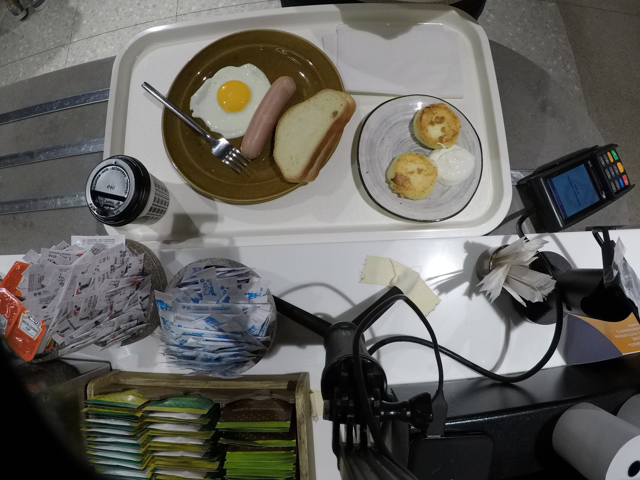

In [69]:
dataset['train'][5]['image'].resize(FUSED_SHAPE)

# NB! Delete after ended

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
drive_path = '/content/drive/MyDrive/datasets/'
# dataset.save_to_disk(drive_path)

In [188]:
bbox_transform = albumentations.Compose(
    [albumentations.Resize(height=FUSED_SHAPE[1], width=FUSED_SHAPE[0]),
     albumentations.HorizontalFlip(p=0.8),
     albumentations.Rotate(p=0.8),
     albumentations.pytorch.transforms.ToTensorV2()],
    bbox_params=albumentations.BboxParams(format='pascal_voc', label_fields=['labels'])
)

In [169]:
images = [dataset['train'][i]['image'] for i in range(10)]
objects = [dataset['train'][i]['objects'] for i in range(10)]

In [81]:
np.array(images[0].convert('RGB')).shape

(3000, 4000, 3)

In [136]:
dataset['train'][5]['objects']['bbox'][0][0] / 4000

2408.8

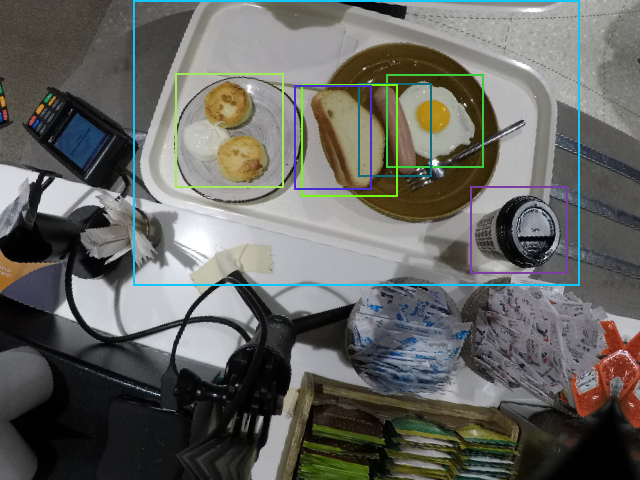

In [207]:
objects = [dataset['train'][i]['objects'] for i in range(10)]

class AlfaFoodDataset(Dataset):


    def __init__(self, images, objects, transform=None):
        self.images = images
        self.objects = objects
        self.transform = transform


    def __getitem__(self, index: int) -> Tuple[torch.Tensor, Tuple[Tuple[int]], Tuple[int]]:
        "Returns one sample of data: image, labels, bboxes"

        image = np.array(self.images[index].convert('RGB'))#.transpose(1, 2, 0)
        bboxes = self.objects[index]['bbox']
        labels = self.objects[index]['categories']

        if self.transform:
            for bbox in bboxes:
                # bbox[0] = bbox[0] / original_shape[0]
                # bbox[2] = bbox[2] / original_shape[0]
                # bbox[1] = bbox[1] / original_shape[1]
                # bbox[3] = bbox[3] / original_shape[1]

                bbox[2] += bbox[0]
                bbox[3] += bbox[1]

            # print(bboxes)
            transformed = self.transform(image = image, bboxes = bboxes, labels = labels)
            image = np.array(transformed['image']).transpose(1, 2, 0)
            bboxes = transformed['bboxes']
            labels = transformed['labels']

        return image, bboxes, labels


    def __len__(self):
        "Returns the total number of samples."
        return len(self.images)

data = AlfaFoodDataset(images, objects, transform = bbox_transform)
# data = AlfaFoodDataset(images, objects)

img, bboxes, labels = data[5]
# print(bboxes)
# Image.fromarray(img)
img1 = Image.fromarray(img)
color = tuple((random.randint(0, 200), random.randint(0, 250), random.randint(0, 255)) for i in range(100))

# color = random.shuffle(color)

for i in range(len(bboxes)):
    draw = ImageDraw.Draw(img1)
    draw.rectangle(bboxes[i], outline = color[i], width=2)

# plt.imshow(img.transpose(1, 2, 0))
# print(bboxes[0])
img1